# A. Tank model calibration and validation

The Tank model was first developed by Sugawara of Japan in 1961 (Sugawara, 1995) and is a widely used conceptual hydrologic model in many countries, including South Korea (Ou et al. 2017; Goodarzi et al., 2020). This model is comprised of several vertically arranged storage tanks representing the zonal structure of groundwater in the target catchment (Phuong et al., 2018). From top to bottom, each tank represents the surface and subsurface flow, intermediate flow, sub-base flow, and base flow (Shin et al., 2010), respectively. The modified Tank model, incorporating soil moisture structure and snowmelt modules, is widely used in South Korea for long-term water resources planning and management (Kang et al., 2004; Lee et al., 2020).

![Tank_model.jpg](util/images/Tank_model.jpg)

## 1. Import libraries
Now, we need to import the necessary libraries and tools (🚨 in order to run the code like in the box below, place the mouse pointer in the cell, then click on “run cell” button above or press shift + enter).

In [1]:
import glob
import os, re
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import font_manager, rc
path = os.getcwd()

## 2. Model calibration

### 2.1. Settings

In [2]:
# Input simulation information
catchment_name = 'A'                   # Define the name of the catchment
ratio = {'A':0.23, 'B':0.605}          # Ratio of Loss/PET which is defined manually (see hydrologic_data.xlsx)
area = {'A':2073.0, 'B':1584.0}        # Catchment area (square kilometer)
sim_title = catchment_name + '_cal'    # Simulation title
loss_et_ratio = ratio[catchment_name]  # Call the ET loss ratio defined above for the catchment
catch_area =  area[catchment_name]     # Call the catchment area defined above for the catchment
# Define calibration start and end year/month/day
start_year = 2001
start_month = 1
start_day = 1
start_date = str(start_month).zfill(2) + '/' + str(start_day).zfill(2) + '/' + str(start_year) # Set as date type (mm/dd/yyyy)
end_year = 2010
end_month = 12
end_day = 31
end_date = str(end_month).zfill(2) + '/' + str(end_day).zfill(2) + '/' + str(end_year)         # Set as date type (mm/dd/yyyy)

### 2.2. Define default parameters

There are 7 initial conditions and 21 parameters for Tank simulation. Initial conditions are the basic information for the simulation and parameters represent details of the catachment of interest. Since we are going to optimise these parameters using SCE-UA method, you don't need to change the initial parmenters below.

In [3]:
# Initial conditions (7)
XSI      =  240.0         # Initial condition of first sub tank
XAI      =  0.0           # Initial condition of first main tank
XBI      =  0.0           # Initial condition of second tank
XCI      =  10.0          # Initial condition of third tank
XDI      =  500.0         # Initial condition of fourth tank
S1       =  40.0          # Maximum storage of soil moisture at first main tank
S2       =  250.0         # Maximum storage of soil moisture at first sub tank
# Parameters (21)
K1       =   2.0000060    # Soil moisture exchange coefficient from sencond to first tank
K2       =  20.0000100    # Soil moisture exchange coefficient from S1 to S2
A2       =    .4840125    # Upper runoff coefficient at first tank (unit 1/d) (Surface flow)
A1       =    .1148448    # Lower runoff coefficient at first tank (unit 1/d) (Surface flow)
A0       =    .0942788    # Infiltration coefficient at first tank (unit 1/d)
B1       =    .2335766    # Runoff coefficient at second tank (unit 1/d) (Intermediate flow)
B0       =    .2798826    # Infiltration coefficient at second tank (unit 1/d)
C1       =    .0156474    # Runoff coefficient at third tank (unit 1/d)  (Supplemental baseflow)
C0       =    .0088901    # Infltration coefficient at third tank (unit 1/d)
D1       =    .0002183    # Runoff coefficient at fourth tank (unit 1/d)  (Primary baseflow)
HA2      =  40.0000100    # Upper outlet height at first tank (mm)
HA1      =  15.0000000    # Lower outlet height at first tank (mm)
HB       =    .0000000    # Outlet height at second tank (mm)
HC       =    .0000000    # Outlet height at third tank (mm)
U1       =    .6629812    # Ordinate of unit hydrograph at t day (dimensionless) 
U2       =    .3369802    # Ordinate of unit hydrograph at t+1 day (dimensionless)
SNOSTOR0 =   7.6019280    # Snow storage
T_RAIN   =   5.7158910    # Temperature that all precipitation is considered to be rain
T_SNOW   =  -2.0023430    # Temperature that all precipitation is considered to be snow
MELTMAX  =    .2341034    # Maximum melt rate
ALPHA    =   1.0583050    # Direct runoff fraction

### 2.3. Input data generation

Now, we generate input file for the calibration of Tank simulation.

In [9]:
# If this code is not working, open the input data csv file and change date format as 20000-01-01

for year in range(start_year,end_year + 1):
    for month in range(start_month,end_month + 1):
        # define the path and name of the input file
        file = open(path + '/analysis/1.parameter/' +  sim_title + '_input', "w")
        # allocate simulation information defined in 2.1 Settings.
        file.write(str(sim_title).rjust(10) + "\n")
        file.write(str(catchment_name).rjust(20) + "\n")
        file.write(str(start_date).rjust(10) + str(end_date).rjust(20) + "\n")
        file.write(str(loss_et_ratio).rjust(10) + str(0.0).rjust(10) + "\n")
        file.write(str(catch_area).rjust(10) + "\n")
        # allocate initial parameters defined in 2.2 Define deafult parameters.
        file.write(str(XSI).rjust(20) + str('XSI').rjust(10) + str(SNOSTOR0).rjust(20) + str('SNOSTOR0').rjust(10) + "\n")
        file.write(str(XAI).rjust(20) + str('XAI').rjust(10) + str(T_RAIN).rjust(20) + str('T_RAIN').rjust(10) + "\n")
        file.write(str(XBI).rjust(20) + str('XBI').rjust(10) + str(T_SNOW).rjust(20) + str('T_SNOW').rjust(10) + "\n")
        file.write(str(XCI).rjust(20) + str('XCI').rjust(10) + str(MELTMAX).rjust(20) + str('MELTMAX').rjust(10) + "\n")
        file.write(str(XDI).rjust(20) + str('XDI').rjust(10) + str(ALPHA).rjust(20) + str('ALPHA').rjust(10) + "\n")
        file.write(str(S1).rjust(20) + str('S1').rjust(10) + "\n")
        file.write(str(S2).rjust(20) + str('S2').rjust(10) + "\n")
        file.write(str(K1).rjust(20) + str('K1').rjust(10) + "\n")
        file.write(str(K2).rjust(20) + str('K2').rjust(10) + "\n")
        file.write(str(A2).rjust(20) + str('A2').rjust(10) + "\n")
        file.write(str(A1).rjust(20) + str('A1').rjust(10) + "\n")
        file.write(str(A0).rjust(20) + str('A0').rjust(10) + "\n")
        file.write(str(B1).rjust(20) + str('B1').rjust(10) + "\n")
        file.write(str(B0).rjust(20) + str('B0').rjust(10) + "\n")
        file.write(str(C1).rjust(20) + str('C1').rjust(10) + "\n")
        file.write(str(C0).rjust(20) + str('C0').rjust(10) + "\n")
        file.write(str(D1).rjust(20) + str('D1').rjust(10) + "\n")
        file.write(str(HA2).rjust(20) + str('HA2').rjust(10) + "\n")
        file.write(str(HA1).rjust(20) + str('HA1').rjust(10) + "\n")
        file.write(str(HB).rjust(20) + str('HB').rjust(10) + "\n")
        file.write(str(HC).rjust(20) + str('HC').rjust(10) + "\n")
        file.write(str(U1).rjust(20) + str('U1').rjust(10) + "\n")
        file.write(str(U2).rjust(20) + str('U2').rjust(10) + "\n")
        
        # call the time-series data (csv)
        data = pd.read_csv(path + '/data/' + catchment_name + '_hydrologic_data.csv', skipfooter = 0)  # read input data (daily rain, temp, evapotranspiration)
        
        # allocate the time series data (date, rainfall, flow, ET and temperature) to the input file
        date = list(data['date'])
        rain = list(data['rain'])
        obs_flow = list(data['obs_flow'])
        ET = list(data['et'])
        temp = list(data['temp'])
        # define start and end rows
        start_row = data.index[data['date'] == str(start_year) + '-' + str(start_month).zfill(2) + '-' + str(start_day).zfill(2)].tolist()[0]
        end_row = data.index[data['date'] == str(end_year) + '-' + str(end_month).zfill(2) + '-' + str(end_day).zfill(2)].tolist()[0]
        for index in range(start_row, end_row+1):
                file.write(str(date[index]).rjust(10) + str(rain[index]).rjust(10) + str(obs_flow[index]).rjust(10)  + str(ET[index]).rjust(9) + str(temp[index]).rjust(10) + "\n")
        file.close()
        
print('Input file for calibration has generated!')

Input file for calibration has generated!


### 2.4. Run parameter calibration module

Now, We estimate 21 parameters of the Tank model for the given calibration period. The shuffled complex evolution (SCE-UA) global optimization algorithm, developed at the University of Arizona (Duan et al., 1992, 1994), is major algorithm of this parameter calibration module ('Cal_Tank_Module'). This algorithm has widely been used globally for the calibration of hydrologic models and exhibits more robust and efficient performance compared to many traditional optimization methods such as Genetic Algorithm, Differential Evolution, and Simulated Annealing (Yapo et al., 1996; Rahnamay-Naeini et al., 2019). 

The objective function used for the parameter estimation is based on the following equation proposed by Sugawara in 1986, expressed as

$$ Min.∑_{t=1}^N |{ }q_t^{obs}{ }-{ }q_t^{sim}{ }|{ }  /{ } q_t^{obs} $$

where t, N represent time (in days) and total number of time steps, q_t^obs and q_t^sim represent the observed and simulated flow at time t, respectively.

In [11]:
# Specify the title, path of calibration in batch file
batfile_name = 'calibration.bat'                                                          
bat_file = open(path + '/analysis/1.parameter/' + batfile_name, "w")
bat_file.write(str('Cal_Tank_Module') + " " + str(sim_title) + "_input "  + str('oad'))
bat_file.close()

# Run paramenter calibration module
workingDir = (path + '/analysis/1.parameter/')  # Define working directory
executeFile = (batfile_name)                    # Run the batchfile

def run(path):
    os.chdir(workingDir)
    os.system(path)
run(executeFile)

print('Parameter calibration has completed!')

Parameter calibration has completed!


### 2.5. Plot figures (y-axis, log scale)

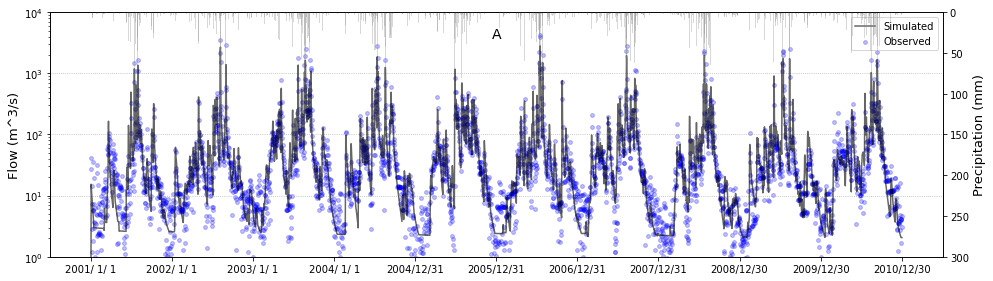

,indicator,values
0,PBIAS =,0.459
1,PEE =,7.204
2,NS =,0.863
3,ROV =,1.005


In [12]:
# call the calibration output file
inputfile = path + '/analysis/1.parameter/' + sim_title[:-2] + '.out'
# allocate output data we need
colspecs = [(0,11), (12,19), (46,55), (56,65)]
reqdata = pd.read_fwf(inputfile, skiprows=48, skipfooter=41, colspecs=colspecs, names=['date_cal', 'rain_cal', 'Q_obs_cal', 'Q_sim_cal'])      

colspecs2 = [(0,14), (14,26)]
parameter = pd.read_fwf(inputfile, skiprows=20, skipfooter=41 + (end_row-start_row) + 7, colspecs=colspecs2, names=['parameter', 'value'])    

colspecs3 = [(0,13), (13,21)]
indicator = pd.read_fwf(inputfile, skiprows=3723, skipfooter=14, colspecs=colspecs3, names=['indicator', 'values']) 

# Plot a figure
x = reqdata['date_cal']
y1 = reqdata['Q_obs_cal']
y2 = reqdata['Q_sim_cal']
r = reqdata['rain_cal']

plt.rcParams["figure.figsize"] = (16,4.5)       # Figure size
fig, ax1 = plt.subplots()                       # subplot designation
ax1.plot(x, y2, color='black', linewidth = 1.5, alpha=0.6, label='Simulated') # line plot for flow
ax1.scatter(x, y1, marker = 'o', color = 'blue', s=15,  alpha=0.25, label='Observed') # scatter plot for obs data
ax1.set_yscale('log')  # change y axis scale (log)
ax1.set_title(str(catchment_name), x=0.5, y=0.87, fontsize=14) # set figure title
ax1.set_ylabel("Flow (m^3/s)",size = 13)        # y-axis title
ax1.set_ylim(1, 10000)                          # set y axis range
plt.grid(True, axis='y', linestyle=':')         # add grid lines
ax1.legend(loc ='upper right')

ax2 = ax1.twinx() # add auxiliary y axis
ax2.bar(x, r, color='grey', width = 3.0, alpha=0.3, label = 'Precipitation') # bar plot for precipitation
ax2.set_ylim(300, 0)                            # set auxiliary y axis range
ax2.set_ylabel("Precipitation (mm)",size = 13)  # auxiliary y axis title
ax2.grid(False, axis='x')                       # remove grid lines for x direction
ax2.grid(False, axis='y')                       # remove grid lines for y direction
plt.xticks(np.arange(0, len(x)+1, 365))         # set x tick 

plt.show()

# save the result data
reqdata.to_csv(path + '/analysis/1.parameter/' + catchment_name + '_q.csv')
parameter.to_csv(path + '/analysis/1.parameter/' + catchment_name + '_parameter.csv')
indicator

## 3. Model validation

### 3.1. Settings

In [13]:
val_title = catchment_name + '_val'   # Define the title of the validation

# Define validation start and end year/month/day
start_year = 2011
start_month = 1
start_day = 1
start_date = str(start_month).zfill(2) + '/' + str(start_day).zfill(2) + '/' + str(start_year) # Set as date type (mm/dd/yyyy)
end_year = 2020
end_month = 12
end_day = 31
end_date = str(end_month).zfill(2) + '/' + str(end_day).zfill(2) + '/' + str(end_year)         # Set as date type (mm/dd/yyyy)

### 3.2. Parameter assimilation

We already generated optimised parameters through the '1.Model calibration' process. For the validation of model for the other time period, now we call the optimised parameters.

In [14]:
# Call the parameters (21) that have been estimated from the calibration.
parameter = pd.read_csv(catchment_name + '_parameter.csv')
K1       = parameter['value'][0]
K2       = parameter['value'][1]
A2       = parameter['value'][2]
A1       = parameter['value'][3]
A0       = parameter['value'][4]
B1       = parameter['value'][5]
B0       = parameter['value'][6]
C1       = parameter['value'][7]
C0       = parameter['value'][8]
D1       = parameter['value'][9]
HA2      = parameter['value'][10]
HA1      = parameter['value'][11]
HB       = parameter['value'][12]
HC       = parameter['value'][13]
U1       = parameter['value'][14]
U2       = parameter['value'][15]
SNOSTOR0 = parameter['value'][16]
T_RAIN   = parameter['value'][17]
T_SNOW   = parameter['value'][18]
MELTMAX  = parameter['value'][19]
ALPHA    = parameter['value'][20]

### 3.3. Input file generation (for validation)

Now, we generate input file for the validation of Tank simulation.

In [16]:
# If this code is not working, open the input data csv file and change date format as 20000-01-01

for year in range(start_year,end_year + 1):
    for month in range(start_month,end_month + 1):
        # define the path and name of the input file
        os.chdir('../')
        file = open(path + '/analysis/2.validation/' + val_title + '.txt', "w")
        # allocate simulation information defined in 3.1. settings.
        file.write(str(val_title).rjust(10) + "\n")
        file.write(str(catchment_name).rjust(20) + "\n")
        file.write(str(start_date).rjust(10) + str(end_date).rjust(20) + "\n")
        file.write(str(loss_et_ratio).rjust(10) + str(0.0).rjust(10) + "\n")
        file.write(str(catch_area).rjust(10) + "\n")
        # allocate estimated parameters defined in 3.2 Parameter assimilation.
        file.write(str(XSI).rjust(20) + str('XSI').rjust(10) + str(SNOSTOR0).rjust(20) + str('SNOSTOR0').rjust(10) + "\n")
        file.write(str(XAI).rjust(20) + str('XAI').rjust(10) + str(T_RAIN).rjust(20) + str('T_RAIN').rjust(10) + "\n")
        file.write(str(XBI).rjust(20) + str('XBI').rjust(10) + str(T_SNOW).rjust(20) + str('T_SNOW').rjust(10) + "\n")
        file.write(str(XCI).rjust(20) + str('XCI').rjust(10) + str(MELTMAX).rjust(20) + str('MELTMAX').rjust(10) + "\n")
        file.write(str(XDI).rjust(20) + str('XDI').rjust(10) + str(ALPHA).rjust(20) + str('ALPHA').rjust(10) + "\n")
        file.write(str(S1).rjust(20) + str('S1').rjust(10) + "\n")
        file.write(str(S2).rjust(20) + str('S2').rjust(10) + "\n")
        file.write(str(K1).rjust(20) + str('K1').rjust(10) + "\n")
        file.write(str(K2).rjust(20) + str('K2').rjust(10) + "\n")
        file.write(str(A2).rjust(20) + str('A2').rjust(10) + "\n")
        file.write(str(A1).rjust(20) + str('A1').rjust(10) + "\n")
        file.write(str(A0).rjust(20) + str('A0').rjust(10) + "\n")
        file.write(str(B1).rjust(20) + str('B1').rjust(10) + "\n")
        file.write(str(B0).rjust(20) + str('B0').rjust(10) + "\n")
        file.write(str(C1).rjust(20) + str('C1').rjust(10) + "\n")
        file.write(str(C0).rjust(20) + str('C0').rjust(10) + "\n")
        file.write(str(D1).rjust(20) + str('D1').rjust(10) + "\n")
        file.write(str(HA2).rjust(20) + str('HA2').rjust(10) + "\n")
        file.write(str(HA1).rjust(20) + str('HA1').rjust(10) + "\n")
        file.write(str(HB).rjust(20) + str('HB').rjust(10) + "\n")
        file.write(str(HC).rjust(20) + str('HC').rjust(10) + "\n")
        file.write(str(U1).rjust(20) + str('U1').rjust(10) + "\n")
        file.write(str(U2).rjust(20) + str('U2').rjust(10) + "\n")
        # call the time series data (csv)        
        data = pd.read_csv(path + '/data/' + catchment_name + '_hydrologic_data.csv', skipfooter = 0)  # Read input data (daily rain, temp, evapotranspiration)
        # allocate the time series data (date, rainfall, flow, ET and temperature) to the input file
        date = list(data['date'])
        rain = list(data['rain'])
        obs_flow = list(data['obs_flow'])
        ET = list(data['et'])
        temp = list(data['temp'])
        # define start and end rows
        start_row = data.index[data['date'] == str(start_year) + '-' + str(start_month).zfill(2) + '-' + str(start_day).zfill(2)].tolist()[0]
        end_row = data.index[data['date'] == str(end_year) + '-' + str(end_month).zfill(2) + '-' + str(end_day).zfill(2)].tolist()[0]
        for index in range(start_row, end_row+1):
                file.write(str(date[index]).rjust(10) + str(rain[index]).rjust(10) + str(obs_flow[index]).rjust(10)  + str(ET[index]).rjust(9) + str(temp[index]).rjust(10) + "\n")
        file.close()
        
print('Input file for validation has generated!')

Input file for validation has generated!


### 3.4. Run Tank model

Input data for the validation of Tank model has been created, and now we can run the Tank model.

In [17]:
# Specify the title, path of validation in batch file
batfile_name = 'validation.bat'
bat_file = open(path + '/analysis/2.validation/' + batfile_name, "w")
bat_file.write(str('Sim_SMTank') + " " + str(val_title) + '.txt' + " "  + str(val_title) + '.out')
bat_file.close()

# Run validation module
workingDir = (path + '/analysis/2.validation/')
executeFile = (path + '/analysis/2.validation/' + batfile_name)

def run(path_val):
    os.chdir(workingDir)
    os.system(path_val)
run(executeFile)

print('Tank model simulation has completed!')

Tank model simulation has completed!


### 3.5. Visualisation (y-axis, log scale) and calculate model performance indicators

The performance of the Tank model was evaluated over a 10-year period from 2011 to 2020 using three evaluation indicators: Nash-Sutcliffe model Efficiency coefficient (NSE), Percentage Bias (PBIAS), and Ratio of Volume (ROV). The calculation of each indicator was carried out as described by the following equations.

$$ NSE=1-  ∑_{t=1}^N (q_t^{obs}- q_t^{sim})^2 / ∑_{t=1}^N (q_t^{obs}- q_{mean}^{sim})^2	$$

$$ PBIAS=∑_{t=1}^N (q_t^{obs}- q_t^{sim})^2  / ∑_{t=1}^N q_t^{obs}×100	$$ 

$$ ROV=∑_{t=1}^N q_t^{sim}  / ∑_{t=1}^N q_t^{obs} $$ 

where t, N, q_t^obs and q_t^sim are as defined in Equation (2), and q_mean^sim represents simulated mean flow across the total number of time steps (N). 

The NSE can range from negative infinity to 1. When NSE equals 1, it indicates a perfect match between the simulated flow and the observed data. A value of NSE equal to zero signifies that the model predictions are as accurate as the mean of the observed data. PBIAS is a metric used to measure the average deviation of the simulated values from the observation data. The optimal value of PBIAS is 0, with low-magnitude values indicating accurate simulation by the model. Positive (negative) values of PBIAS indicate a tendency for overestimation (underestimation) in the simulation. ROV represents the ratio of total volume between the simulated and observed flow. The optimal value of ROV is 1, with a value greater (less) than 1 indicating overestimation (underestimation).

Here, widely adopted measure for the performance of the model, r square and correlation are also calculated.

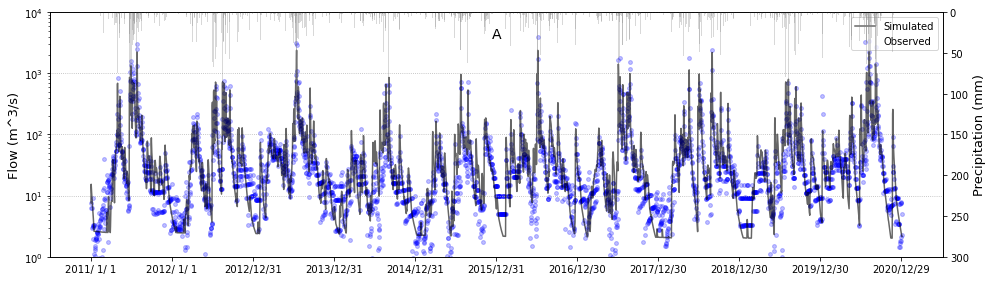

,NSE,PBIAS,ROV,r2,Corr
calibration,0.86,-0.46,1.0,0.86,0.94
validation,0.85,-10.47,1.1,0.85,0.92


In [22]:
# call the validation output file
inputfile = path + '/analysis/2.validation/' + val_title + '.out'
# allocate required output data
colspecs = [(0,11), (12,19), (46,56), (56,65)]
reqdata_val = pd.read_fwf(inputfile, skiprows=48, skipfooter=41, colspecs=colspecs, names=['date_val', 'rain_val', 'Q_obs_val', 'Q_sim_val'])

# Plot a figure
x = reqdata_val['date_val']
y1 = reqdata_val['Q_obs_val']
y2 = reqdata_val['Q_sim_val']
r = reqdata_val['rain_val']

plt.rcParams["figure.figsize"] = (16,4.5)            # Figure size
fig, ax1 = plt.subplots()                            # subplot designation
ax1.plot(x, y2, color='black', linewidth = 1.5, alpha=0.6, label='Simulated')          # line plot for flow
ax1.scatter(x, y1, marker = 'o', color = 'blue', s=15,  alpha=0.25, label='Observed')  # scatter plot for obs data
ax1.set_yscale('log')  # change y axis scale (log)
ax1.set_title(str(catchment_name), x=0.5, y=0.87, fontsize=14) # set figure title
ax1.set_ylabel("Flow (m^3/s)",size = 13)             # y-axis title
ax1.set_ylim(1, 10000)                               # set y axis range
plt.grid(True, axis='y', linestyle=':')              # add grid line for y direction
ax1.legend(loc='upper right')

ax2 = ax1.twinx()  # add auxiliary y axis
ax2.bar(x, r, color='grey', width = 3.0, alpha=0.3, label = 'Precipitation')            # bar plot for precipitation
ax2.set_ylim(300, 0)                                 # set auxiliary y axis range
ax2.set_ylabel("Precipitation (mm)",size = 13)       # auxiliary y axis title
ax2.grid(False, axis='x')             # add grid line for x direction
ax2.grid(False, axis='y')              # add grid line for y direction
plt.xticks(np.arange(0, len(x)+1, 365))              # set x tick 

plt.show()

# save the result data
result = pd.concat([reqdata,reqdata_val],axis=1)
result.to_csv(path + '/analysis/2.validation/' + 'result_' + val_title + '.csv')

# calculate indicators measuring the performance of the model
# for calibaration
PBIAS_cal = round((result['Q_obs_cal'] - result['Q_sim_cal']).sum()/result['Q_obs_cal'].sum()*100, 2)
NSE_cal = round(1 - (result['Q_obs_cal'] - result['Q_sim_cal']).pow(2).sum()/(result['Q_obs_cal']-result['Q_obs_cal'].mean()).pow(2).sum(), 2)
ROV_cal = round(result['Q_sim_cal'].sum()/result['Q_obs_cal'].sum(), 2)
Corr_cal = round(result.corr(method ='pearson').loc['Q_obs_cal','Q_sim_cal'], 2)
res_cal = result['Q_obs_cal'].sub(result['Q_sim_cal']).pow(2).sum()
tot_cal = result['Q_obs_cal'].sub(result['Q_obs_cal'].mean()).pow(2).sum()
r2_cal = round(1 - res_cal/tot_cal, 2)
# for validation
PBIAS_val = round((result['Q_obs_val'] - result['Q_sim_val']).sum()/result['Q_obs_val'].sum()*100, 2)                                          
NSE_val = round(1 - (result['Q_obs_val'] - result['Q_sim_val']).pow(2).sum()/(result['Q_obs_val']-result['Q_obs_val'].mean()).pow(2).sum(), 2)
ROV_val = round(result['Q_sim_val'].sum()/result['Q_obs_val'].sum(), 2)                                                                         
Corr_val = round(result.corr(method ='pearson').loc['Q_obs_val','Q_sim_val'], 2)                                                                
res_val = result['Q_obs_val'].sub(result['Q_sim_val']).pow(2).sum()                                                                             
tot_val = result['Q_obs_val'].sub(result['Q_obs_val'].mean()).pow(2).sum()                                                                     
r2_val =round(1 - res_val/tot_val, 2)

# Generate performance indicator csv file
performance_df = pd.DataFrame()
performance_df = pd.DataFrame(columns = ['NSE','PBIAS','ROV','r2','Corr'])
performance_df.loc['calibration'] = [NSE_cal,PBIAS_cal,ROV_cal,r2_cal,Corr_cal]
performance_df.loc['validation'] = [NSE_val,PBIAS_val,ROV_val,r2_val,Corr_val]
# Save the performance indicators as CSV
performance_df.to_csv(path + '/analysis/2.validation/indicator_' + val_title + '.csv')  
performance_df